### Sayan Patra's code:

In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, matplotlib.pyplot as plt, pickle
from tqdm import trange
import scipy, pystan as ps
%matplotlib inline
from time import time
from pylab import plot, show, legend

#### Compile Stan model:

In [2]:
sm = ps.StanModel(file="brain_sayan_core.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cc22e6617bb703b07d6d9af0b6923715 NOW.


#### Load data from file and prepare stan data list:

In [12]:
from numpy import loadtxt

X = np.zeros((42,68,68))
for i in range(42) :
    name = "/home/postdoc/dsen/Desktop/projeted_posterior/brain_data/data_column"+str(i+1)
    X[i] = loadtxt(name, comments="#", delimiter=" ", unpack=False)
X = X.astype(int)

# N = 21 
# m = np.shape(X)[1]
# p = 10
# a = 1/m
# data = dict(N=N, m=m, p=p, X=X[:N], alpha=1/m, lmbda=0.5)

N = 10
m = 10
p = 5
data = dict(N=N, m=m, p=p, X=X[:N,:m,:m], alpha=1./m, tau=1e-3)

print(np.mean(X[:N,:m,:m]))

0.566


#### Initialise parameters for sampling:

In [13]:
Z_ini = npr.randn(m,m)
pp = np.mean(X[:N,:m,:m],0)
pp[pp==0] = 0.01
pp[pp==1] = 0.99

eg_p = np.linalg.eig(np.log(pp/(1-pp)))
U_ini = eg_p[1][:,:p]
D_ini = np.transpose(np.reshape(np.ravel([np.abs(eg_p[0][:p])]*N), (p,N), order='C'))

etaU_ini= npr.rand(m,p)
sigsqZ_ini = npr.rand()
sigsqD_ini = npr.rand(p)

def initfun():
    return dict(Z=Z_ini, U=U_ini, D=D_ini, etaU=etaU_ini, sigsqZ=sigsqZ_ini, sigsqD=sigsqD_ini)

#### Sample using stan:

In [14]:
control = dict(max_treedepth=10)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=4, chains=4, iter=1_000, init=initfun, control=control)
print(round((time()-start)/60,2), "minutes to run")
print(fit)
trace = fit.extract()

2.11 minutes to run
Inference for Stan model: anon_model_cc22e6617bb703b07d6d9af0b6923715.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Z[1,1]      -1.36     0.6   1.34  -4.16  -2.43  -0.75  -0.47   0.89      5   1.57
Z[2,1]      -1.19    0.24   0.44  -1.83  -1.75  -1.12  -0.83  -0.45      3   2.34
Z[3,1]       2.64    0.34   0.68   1.49   2.21   2.58   2.91   4.14      4   1.87
Z[4,1]       1.05    0.38   0.58   0.08   0.37   1.22   1.47   1.81      2   4.19
Z[5,1]       0.97    0.17    0.4   0.26   0.71    0.9   1.13   1.91      6   1.46
Z[6,1]      -1.91    0.44    0.7  -2.77  -2.67   -2.0  -1.06  -0.97      3   2.42
Z[7,1]       1.96     0.4   0.67   0.86   1.31   2.09   2.71    2.8      3   2.91
Z[8,1]       2.08    1.17   1.67  -0.23   0.66   1.87   3.54   4.74      2   9.58
Z[9,1]       2.03    0.48   0.72    1.2   1.31   1.84  

#### Plot posterior samples of prediction probability:

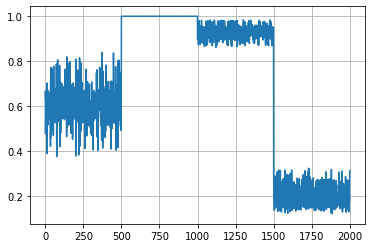

In [15]:
n = 0

Nsamples = np.shape(trace['U'])[0]
ZUDU = np.zeros((Nsamples, m, m))
for idx in range(Nsamples) :
    ZUDU[idx] = np.matmul(np.matmul(trace['U'][idx], np.diag(trace['D'][idx,n])), trace['U'][idx].transpose())
ZUDU += trace['Z']

i, j = 1, 1
predictive = 1/(1+np.exp(-ZUDU))
plt.plot(predictive[:,i,j])
plt.grid(True)

#### Plot log-likelihoods of posterior samples:

In [16]:
def log_ll(X, Z, U, D) :
    ll = 0
    N = np.shape(X)[0]
    prob = np.zeros(np.shape(X))
    for n in range(N) :
        ZUDU = Z + np.matmul(np.matmul(U, np.diag(D[n])), U.transpose())
        probs = 1/(1+np.exp(-ZUDU))
        probs[probs==1] = 1-1e-10
        probs[probs==0] = 1e-10
        ll += np.sum(X[n]*np.log(probs) + (1-X[n])*np.log(1-probs))
        prob[n] = probs
    return ll, prob

In [17]:
log_lls = np.zeros(Nsamples)
probs = np.zeros((Nsamples,*np.shape(X[:N,:m,:m])))
for i in range(Nsamples) :
    log_lls[i], probs[i] = log_ll(X[:N,:m,:m], trace['Z'][i], trace['U'][i], trace['D'][i])

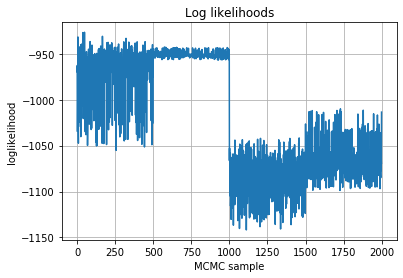

In [18]:
plt.plot(log_lls)
plt.grid(True)
plt.title("Log likelihoods");
plt.xlabel("MCMC sample");
plt.ylabel("loglikelihood");

In [19]:
np.max(probs), np.min(probs)

(0.999999999999782, 4.45840567220302e-05)

#### Plot posterior means of $U$'s:

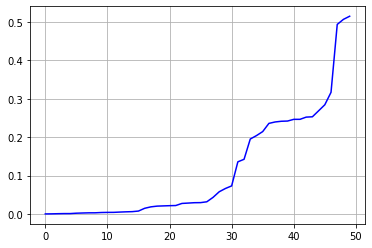

In [20]:
plt.plot(np.sort(np.abs(np.mean(trace['U'],0)).flatten()), 'b-')
plt.grid(True)